# Plots of Main file
Logistic Regression

In [24]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import spearmanr


#set style
sns.set_theme(style="whitegrid")
T=1.6

def logistic_model(x, a, C, K_1, K_2, K_3, K_4):
    return a * (1+C * np.exp(x[0]/T)) / (C * np.exp(x[0]/T) + K_1 * np.exp(x[1]/T) + K_2 * np.exp(x[2]/T) + K_3 * np.exp(x[3]/T) + K_4 * np.exp(x[4]/T) + 1)
parameter_bounds = ([0, 0, 0, 0, 0, 0],
                    [np.inf, np.inf, np.inf, np.inf, np.inf , np.inf])
initial_guess = [1,  1e-8, 1e-8, 1e-8, 1e-8, 1e-8]




In [25]:
df = pd.read_csv('../data/fitness_data.csv')
df['mutations_x'] = df['mutations_x'].str.replace('[', '')
df['mutations_x'] = df['mutations_x'].str.replace(']', '')
df['mutations_x'] = df['mutations_x'].str.replace(' ', '')

df['mutations_x'] = df['mutations_x'].str.replace("'", '')
df['mutations_x'] = df['mutations_x'].str.replace("''", '')

# create list of mutations
df['mutations_x'] = df['mutations_x'].apply(lambda x: x.split(','))
df['mutations_x'] = df['mutations_x'].apply(lambda x: list(x))
df = df.rename(columns={'delta': 'deltaG_fold'})

# drop if log10Kd_ACE2 is 5
df = df[df['log10Kd_ACE2'] != 5]
df['real_f'] = df['s'].values + 1
features = ['log10Kd_ACE2', 'log10Kd_CB6',
            'log10Kd_CoV555', 'log10Kd_REGN10987', 'log10Kd_S309']

for feature in features:
    new_column_name = 'ln_' + feature[5:]
    # Calculate natural logarithm by multiplying log to base 10 value by ln(10)
    df[new_column_name] = df[feature] * np.log(10)

ln_features = ['ln_Kd_ACE2', 'ln_Kd_CB6',
               'ln_Kd_CoV555', 'ln_Kd_REGN10987', 'ln_Kd_S309']
print(df[ln_features].describe())



         ln_Kd_ACE2     ln_Kd_CB6  ln_Kd_CoV555  ln_Kd_REGN10987    ln_Kd_S309
count  32565.000000  32565.000000  32565.000000     32565.000000  32565.000000
mean      19.966415     16.334477     16.226086        19.105824     20.409144
std        1.609653      4.863255      4.458415         4.792152      0.658289
min       15.831589     11.512925     11.512925        11.512925     17.696580
25%       18.714290     11.512925     11.512925        11.512925     19.950611
50%       20.210212     18.461139     16.435928        21.563236     20.437766
75%       21.350267     21.136555     20.702641        22.626989     20.901937
max       23.118244     24.317747     24.542330        24.880015     23.056486


In [26]:
# only work with existing variants
df_existing = df[df['count'] > 0]
df=df_existing 


mu='S:T478K'
#keep only points without 'S:T478K' in mutations_x
df_without = df_existing[~df_existing['mutations_x'].apply(lambda x: mu in x)]
#keep only points with 'S:T478K' in mutations_x
df_with = df_existing[df_existing['mutations_x'].apply(lambda x: mu in x)]


In [27]:
print('number of points without S:T478K in mutations_x: ', len(df_without))
print('number of points with S:T478K in mutations_x: ', len(df_with))

number of points without S:T478K in mutations_x:  362
number of points with S:T478K in mutations_x:  756


# Analysis of data

In [28]:
mutations=['S:G339D',
 'S:S371L',
 'S:S373P',
 'S:S375F',
 'S:K417N',
 'S:N440K',
 'S:G446S',
 'S:S477N',
 'S:T478K',
 'S:E484A',
 'S:Q493R',
 'S:G496S',
 'S:Q498R',
 'S:N501Y',
 'S:Y505H']



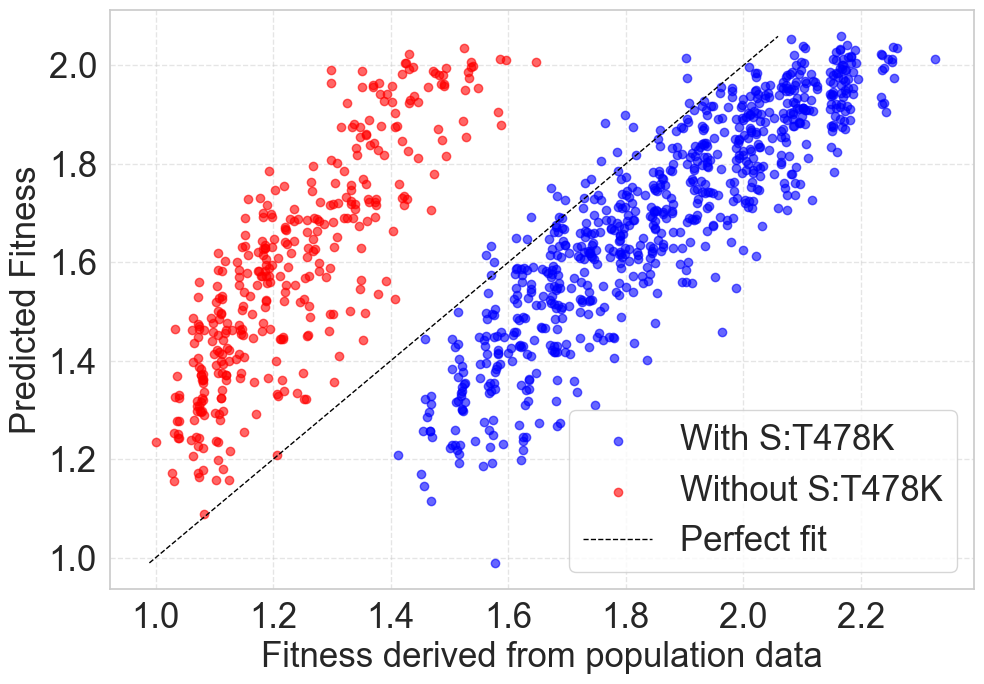

In [29]:
# Fit a linear regression model
X = df_existing[ln_features].values
y = df_existing['real_f'].values
parameters, _ = curve_fit(logistic_model, X.T, y, p0=initial_guess,
                          bounds=parameter_bounds, method='trf', maxfev=1000000)
# Extract the fitted parameters
a, C, K_1, K_2, K_3, K_4 = parameters

X_with = df_with[ln_features].values
y_with = df_with['real_f'].values
y_with_pred = logistic_model(X_with.T, a, C, K_1, K_2, K_3, K_4)

X_without = df_without[ln_features].values
y_without = df_without['real_f'].values
y_without_pred = logistic_model(X_without.T, a, C, K_1, K_2, K_3, K_4)

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 7))

# Plot the data points
plt.scatter(y_with, y_with_pred, label='With ' + mu, color='blue', alpha=0.6)
plt.scatter(y_without, y_without_pred, label='Without ' + mu, color='red', alpha=0.6)
plt.plot(np.unique(y_with_pred), np.unique(y_with_pred), color='black', linestyle='--', linewidth=1, label='Perfect fit')
plt.xlabel('Fitness derived from population data', fontsize=25)  
plt.ylabel('Predicted Fitness', fontsize=25)  
plt.legend(fontsize=25)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.savefig('../paper/log_F_fit_totalset.png', dpi=300)
# fig.savefig('log_F_fit_totalset.eps',  dpi=1200)
plt.show()


In [30]:
#concatenate with and without
concat_pred=np.concatenate((y_with_pred,y_without_pred))
concat_fit=np.concatenate((y_with,y_without))
#R2
print('R2: ', r2_score(concat_fit, concat_pred))
#spearman
print('spearman: ', spearmanr(concat_fit, concat_pred))

R2:  0.4057815652030957
spearman:  SignificanceResult(statistic=0.6723461564159007, pvalue=5.856976421320763e-148)


# 2 logistics

R^2 test: 0.8706206877283964
R^2 train: 0.9842345708380055


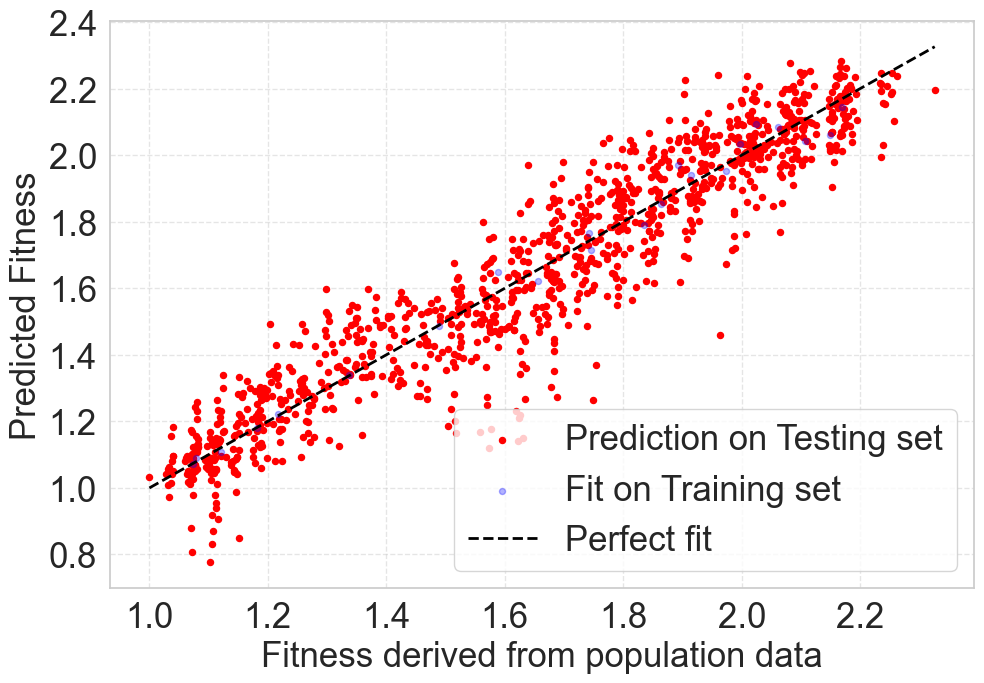

In [31]:
R2tests = []
R2trains = []   
for i in range(10):
    test_size =  0.98
    
    data=df_without
    X = data[ln_features].values
    # take exponential of all values in X
    y = data['real_f'].values
    # Split the data into train and test sets
    X_train, X_test, y_train_without, y_test_without = train_test_split(
        X, y, test_size=test_size, random_state=i)

    # Create and train the logistic
    parameters, _ = curve_fit(logistic_model, X_train.T, y_train_without, p0=initial_guess,
                                bounds=parameter_bounds, method='trf', maxfev=1000000)
    # Extract the fitted parameters
    a_wo, C_wo, K_1_wo, K_2_wo, K_3_wo, K_4_wo = parameters
    y_pred_without = logistic_model(X_test.T, a_wo, C_wo, K_1_wo, K_2_wo, K_3_wo, K_4_wo)
    y_fit_without = logistic_model(X_train.T, a_wo, C_wo, K_1_wo, K_2_wo, K_3_wo, K_4_wo)
    r2_without = r2_score(y_test_without, y_pred_without)




    data=df_with
    X = data[ln_features].values
    y = data['real_f'].values
    # Split the data into train and test sets
    X_train, X_test, y_train_with, y_test_with = train_test_split(
        X, y, test_size=test_size, random_state=0)

    # Create and train the logistic
    parameters, _ = curve_fit(logistic_model, X_train.T, y_train_with, p0=initial_guess,
                                bounds=parameter_bounds, method='trf', maxfev=1000000)
    # Extract the fitted parameters
    a_w, C_w, K_1_w, K_2_w, K_3_w, K_4_w = parameters

    y_pred_with = logistic_model(X_test.T, a_w, C_w, K_1_w, K_2_w, K_3_w, K_4_w)
    y_fit_with = logistic_model(X_train.T, a_w, C_w, K_1_w, K_2_w, K_3_w, K_4_w)



    concat_pred=np.concatenate((y_pred_with,y_pred_without))
    concat_fit=np.concatenate((y_fit_with,y_fit_without))
    concat_test=np.concatenate((y_test_with,y_test_without))
    concat_train=np.concatenate((y_train_with,y_train_without))
    r2_testconcat = r2_score(concat_test, concat_pred)
    r2_trainconcat = r2_score(concat_train, concat_fit)
    R2tests.append(r2_testconcat)
    R2trains.append(r2_trainconcat)
print("R^2 test:",np.mean(R2tests) )
print("R^2 train:",np.mean(R2trains) )


#plot conccat_pred vs concat_test
plt.figure(figsize=(10, 7))
plt.scatter(concat_test, concat_pred,  color='red', alpha=1, label='Prediction on Testing set', s=19)
plt.scatter(concat_train, concat_fit,  color='blue', alpha=0.3, label='Fit on Training set', s=19)

plt.plot(np.unique(concat_test), np.unique(concat_test), color='black', linestyle='--', linewidth=2, label='Perfect fit')
plt.xlabel('Fitness derived from population data', fontsize=25)
plt.ylabel('Predicted Fitness', fontsize=25)

plt.legend(fontsize=25)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.savefig('../paper/log_pred_train_test.png', dpi=300)

plt.show()




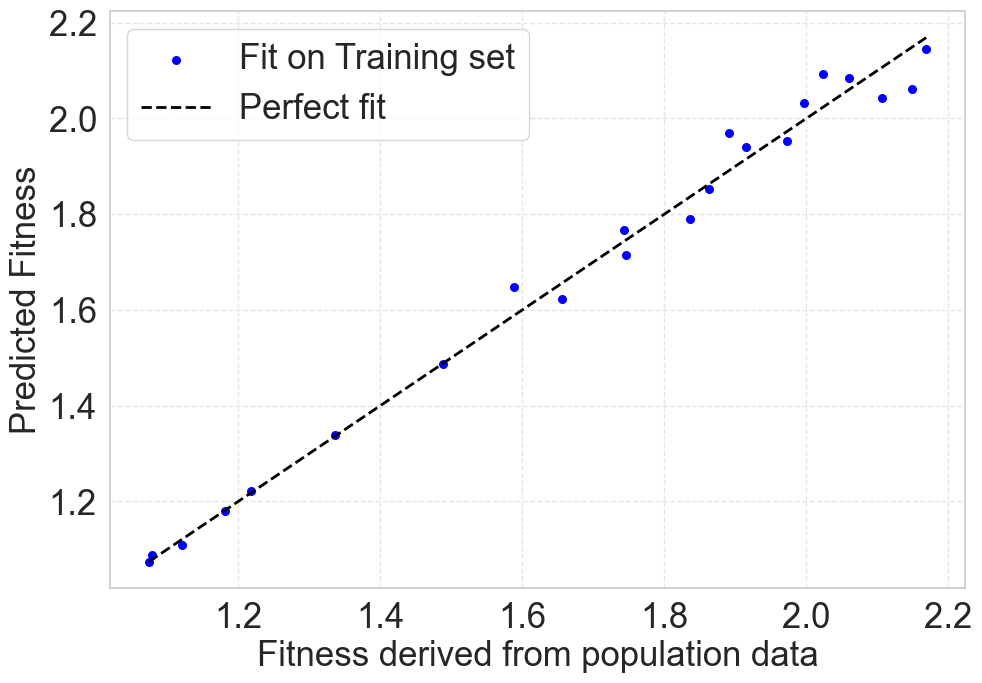

R^2: 0.9881017461178369


In [32]:
# Plot for the Training Set
plt.figure(figsize=(10, 7))
plt.scatter(concat_train, concat_fit, color='blue',  label='Fit on Training set', s=30)
plt.plot(np.unique(concat_train), np.unique(concat_train), color='black', linestyle='--', linewidth=2, label='Perfect fit')
plt.xlabel('Fitness derived from population data', fontsize=25)
plt.ylabel('Predicted Fitness', fontsize=25)
plt.legend(fontsize=25)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout()
# plt.savefig('log_pred_train.eps', dpi=1200)
plt.savefig('../paper/log_pred_train.png', dpi=300)
plt.show()
print("R^2:",r2_score(concat_train, concat_fit))

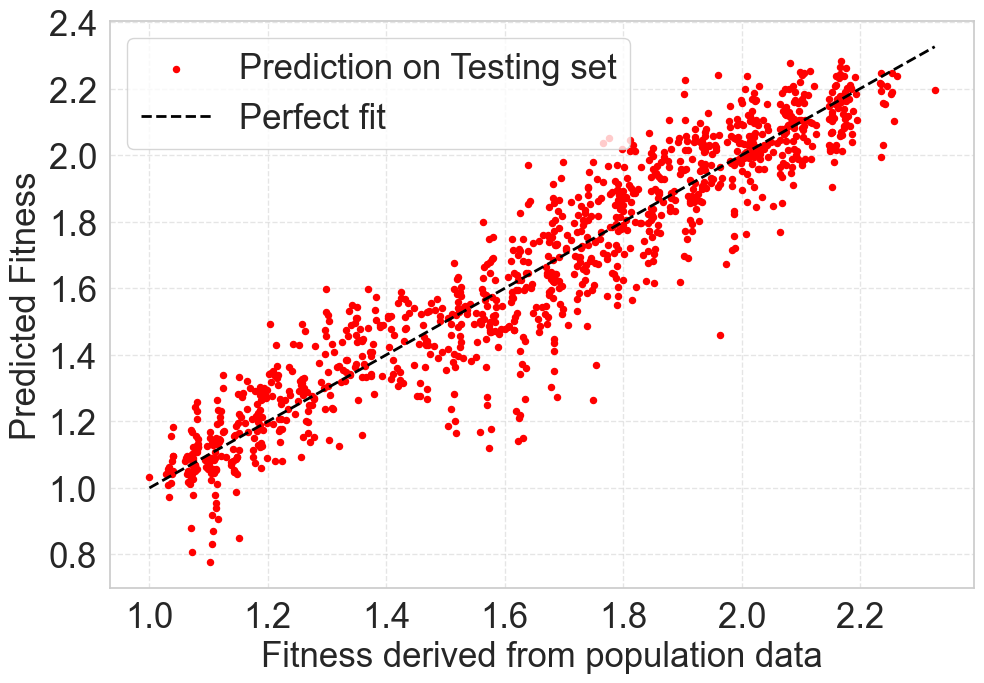

R^2: 0.8835103995526858


In [33]:
# Plot for the Testing Set
plt.figure(figsize=(10, 7))
plt.scatter(concat_test, concat_pred, color='red', alpha=1, label='Prediction on Testing set', s=19)
plt.plot(np.unique(concat_test), np.unique(concat_test), color='black', linestyle='--', linewidth=2, label='Perfect fit')
plt.xlabel('Fitness derived from population data', fontsize=25)
plt.ylabel('Predicted Fitness', fontsize=25)

plt.legend(loc='upper left',  fontsize=25)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout()
# plt.savefig('log_pred_test.eps', dpi=1200)
plt.savefig('../paper/log_pred_test.png', dpi=300)
plt.show()
print("R^2:",r2_score(concat_test, concat_pred))

In [34]:
a_w, C_w,K_1_w, K_2_w, K_3_w, K_4_w

(2.4305134744709576,
 1.1350325527397372e-06,
 2.2218953956915794e-07,
 2.8690305519686317e-08,
 4.2963595410516166e-08,
 8.924414208375083e-07)

In [35]:
a_wo, C_wo,K_1_wo, K_2_wo, K_3_wo, K_4_wo

(1.7874859272542323,
 1.5590353473123565e-07,
 2.0085138204025605e-29,
 2.6865253356648722e-08,
 9.068388522084646e-08,
 8.180377162520174e-07)

In [36]:

x_w = df[df['mutations_x'].apply(lambda x: mu in x)][ln_features].values
y_w = logistic_model(x_w.T, a_w, C_w, K_1_w, K_2_w, K_3_w, K_4_w)

#do the same for without
x_wo = df[df['mutations_x'].apply(lambda x: mu not in x)][ln_features].values
y_wo = logistic_model(x_wo.T, a_wo, C_wo, K_1_wo, K_2_wo, K_3_wo, K_4_wo)
# Add default value for new column
df['logistic_fitness'] = np.nan
# Filter rows where mu is in mutations_x and assign y_w values to the logistic_f column
mask_w = df['mutations_x'].apply(lambda x: mu in x)
df.loc[mask_w, 'logistic_fitness'] = y_w
# Filter rows where mu is not in mutations_x and assign y_wo values to the logistic_f column
mask_wo = df['mutations_x'].apply(lambda x: mu not in x)
df.loc[mask_wo, 'logistic_fitness'] = y_wo


In [37]:
#save the df to csv
# df.to_csv('logistic_fitness.csv', index=False)

Text(0, 0.5, 'Predicted Fitness')

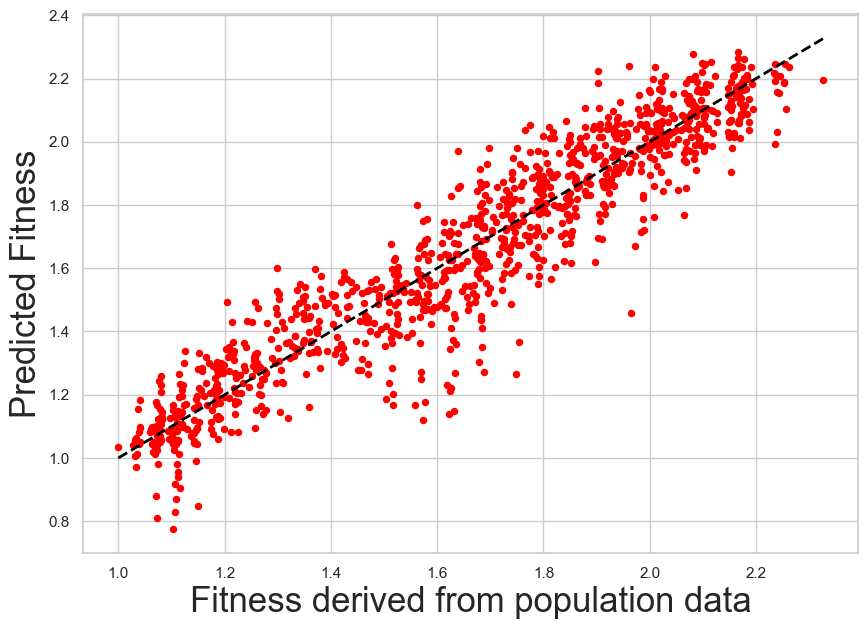

In [38]:
df_e = df[df['count'] > 0]
#scatter logistic fitness vs real fitness
plt.figure(figsize=(10, 7))
plt.scatter(df_e['real_f'], df_e['logistic_fitness'],  color='red', alpha=1, label='Prediction on Testing set', s=19)
plt.plot(np.unique(df_e['real_f']), np.unique(df_e['real_f']), color='black', linestyle='--', linewidth=2, label='Perfect fit')
plt.xlabel('Fitness derived from population data', fontsize=25)
plt.ylabel('Predicted Fitness', fontsize=25)


# Mutation impact

In [39]:
#fit a linear regression on df_with and df_without
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

data=df_without
linear_regression_without=LinearRegression()
linear_regression_without.fit(data[ln_features],data['real_f'])
y_pred_without=linear_regression_without.predict(data[ln_features])
#print r2
print("R^2 without:", r2_score(data['real_f'], y_pred_without))

data=df_with
linear_regression_with=LinearRegression()
linear_regression_with.fit(data[ln_features],data['real_f'])
y_pred_with=linear_regression_with.predict(data[ln_features])
#print r2
print("R^2 with:", r2_score(data['real_f'], y_pred_with))

R^2 without: 0.8427974668041401
R^2 with: 0.8223991199539347


In [40]:
# Concatenating the predictions y_pred_with and y_pred_without
y_pred_combined = pd.concat([pd.Series(y_pred_with), pd.Series(y_pred_without)])

# Concatenating the actual values from df_with and df_without
real_f_combined = pd.concat([df_with['real_f'], df_without['real_f']])

# Calculating R^2 for the combined predictions and actual values
r2_combined = r2_score(real_f_combined, y_pred_combined)

r2_combined


0.950209793514113

In [41]:
for feat in features:
    df_with['fit_'+feat]=df_with[feat].apply(lambda x: linear_regression_with.coef_[features.index(feat)]*(x-df_with[feat].iloc[0]))
    df_without['fit_'+feat]=df_without[feat].apply(lambda x: linear_regression_without.coef_[features.index(feat)]*(x-df_without[feat].iloc[0]))

new_df=pd.concat([df_with,df_without])
new_df['geno'] = new_df['geno'].astype(str)

new_df['binary'] = new_df['geno'].apply(lambda x: x.zfill(15))
new_df['binary'] = new_df['binary'].apply(lambda x: [int(i) for i in x])

/var/folders/4s/fnn1b0255fb95977rmg73gx40000gn/T/ipykernel_6441/1445754716.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with['fit_'+feat]=df_with[feat].apply(lambda x: linear_regression_with.coef_[features.index(feat)]*(x-df_with[feat].iloc[0]))
/var/folders/4s/fnn1b0255fb95977rmg73gx40000gn/T/ipykernel_6441/1445754716.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without['fit_'+feat]=df_without[feat].apply(lambda x: linear_regression_without.coef_[features.index(feat)]*(x-df_without[feat

In [42]:
#fit a first order epistatic model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

#same with 10 fold cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
mutation_names = ['G339D', 'S371L', 'S373P', 'S375F', 'K417N', 'N440K', 'G446S', 'S477N',
                  'T478K', 'E484A', 'Q493R', 'G496S', 'Q498R', 'N501Y', 'Y505H']
coeffs=[]
for fit_feat in ['fit_log10Kd_ACE2','fit_log10Kd_CB6', 'fit_log10Kd_CoV555', 'fit_log10Kd_REGN10987', 'fit_log10Kd_S309']:
 

    regr=LinearRegression()
    regr.fit(new_df['binary'].to_list(), new_df[fit_feat].to_list())
    coeffs.append(regr.coef_)


print (coeffs)
#add sum of coeffs
print(np.sum(coeffs,axis=0))

[array([-5.76087131e-05, -2.00831538e-03,  2.73538839e-04,  3.39482944e-03,
       -9.62958052e-03,  4.25753869e-03, -3.47099953e-03,  7.59765610e-03,
        4.90817858e-04,  1.11681296e-03, -5.55972445e-03, -6.23384210e-03,
        9.34287032e-03,  3.27435317e-02, -1.36910660e-02]), array([-0.00034017,  0.00076214,  0.00042877, -0.00151361,  0.0467938 ,
       -0.00040317, -0.00011628,  0.00078326,  0.00877027,  0.00197891,
        0.00628566,  0.00134074,  0.00139141,  0.00162578,  0.00069389]), array([-0.00118687, -0.00019647,  0.00192102,  0.00553776, -0.00075806,
       -0.00016919,  0.00287529,  0.0004163 ,  0.0148349 ,  0.02330526,
        0.03020353,  0.00064721,  0.00185451,  0.00098924,  0.00056312]), array([-0.00202203,  0.00289823,  0.00088274,  0.00113866, -0.00062652,
        0.02442311,  0.0260412 , -0.00184223,  0.00545581, -0.00174892,
       -0.00176293,  0.00271142,  0.00088714, -0.00149526, -0.00058061]), array([ 0.02962371,  0.00288977,  0.03106716,  0.02292041, -

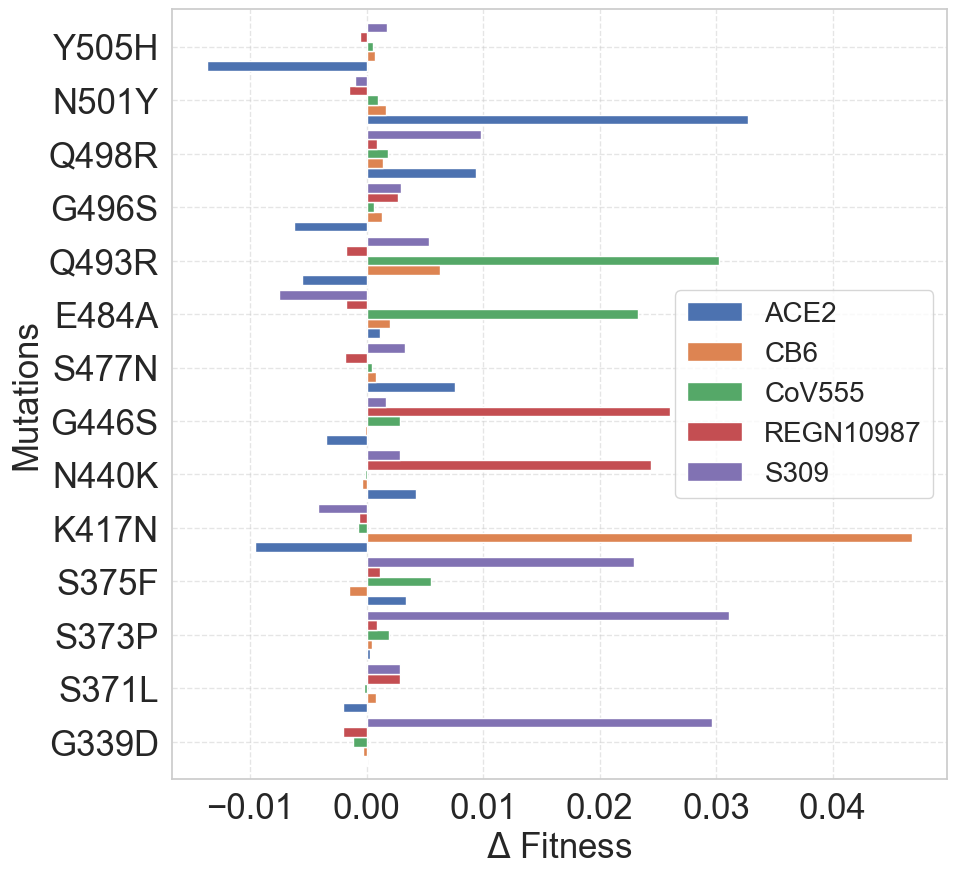

In [43]:
#create a bar plot of coeffs
coeffs_bis=np.array(coeffs)
coeffs_bis=coeffs_bis.reshape(5,15)
coeffs_bis=coeffs_bis.transpose()
index_drop=8# remove T478K
coeffs_bis=np.delete(coeffs_bis, index_drop, 0)
# if T478K in the list
if 'T478K' in mutation_names:
    mutation_names.remove('T478K')
coeffs_bis=pd.DataFrame(coeffs_bis,columns=['ACE2','CB6', 'CoV555', 'REGN10987', 'S309'])
coeffs_bis['mutation']=mutation_names
coeffs_bis=coeffs_bis.set_index('mutation')

coeffs_bis.plot.barh(figsize=(10, 10), width=0.9) 
plt.tick_params(axis='both', labelsize=25)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('$\Delta$ Fitness', fontsize=25)
plt.ylabel('Mutations', fontsize=25)
plt.legend(fontsize=20)
plt.savefig('../paper/contribution_of_mutations.png', dpi=300)

plt.show()



# Error bars on coeffs of the fit

In [44]:
mu='S:T478K'
features=['log10Kd_ACE2','log10Kd_CB6', 'log10Kd_CoV555', 'log10Kd_REGN10987', 'log10Kd_S309','deltaG_fold']

print('Removing mutation: ',mu)



df_shuffled = df.sample(frac=1, random_state=42)
df_shuffled = df_shuffled.reset_index(drop=True)

# Split the dataset into 10 folds
num_folds = 10
fold_size = len(df_shuffled) // num_folds

# Create empty list to store the subsets
subsets = []

# Split the dataset into folds
for i in range(num_folds):
    start_idx = i * fold_size
    end_idx = (i + 1) * fold_size
    fold = df_shuffled[start_idx:end_idx]
    subsets.append(fold)    
coeffs_without=[]
coeffs_with=[]

for dfsplit in subsets:
    df_with_sub = dfsplit[dfsplit['mutations_x'].apply(lambda x: mu in x)]
    df_without_sub = dfsplit[~dfsplit['mutations_x'].apply(lambda x: mu in x)]
    data=df_without_sub
    X = data[ln_features].values
    y = data['real_f'].values
    parameters, _ = curve_fit(logistic_model, X.T, y, p0=initial_guess,
                            bounds=parameter_bounds, method='trf', maxfev=1000000)
    # Extract the fitted parameters
    a, C, K_1, K_2, K_3, K_4 = parameters
    #add to coeffs_without
    coeffs_without.append([a, C, K_1, K_2, K_3, K_4])


    data=df_with_sub
    X = data[ln_features].values
    y = data['real_f'].values
    parameters, _ = curve_fit(logistic_model, X.T, y, p0=initial_guess,
                            bounds=parameter_bounds, method='trf', maxfev=1000000)  
    # Extract the fitted parameters
    a, C, K_1, K_2, K_3, K_4 = parameters
    #add to coeffs_with
    coeffs_with.append([a, C, K_1, K_2, K_3, K_4])
    

#coeffs_with: get the mean of each coeff and standard deviation
coeffs_with=np.array(coeffs_with)
coeffs_with_mean=np.mean(coeffs_with,axis=0)
coeffs_with_std=np.std(coeffs_with,axis=0)


#same for coeffs_without
coeffs_without=np.array(coeffs_without)
coeffs_without_mean=np.mean(coeffs_without,axis=0)
coeffs_without_std=np.std(coeffs_without,axis=0)

coeffs_with_mean=np.array(coeffs_with_mean)
coeffs_with_std=np.array(coeffs_with_std)
coeffs_without_mean=np.array(coeffs_without_mean)
coeffs_without_std=np.array(coeffs_without_std)






Removing mutation:  S:T478K


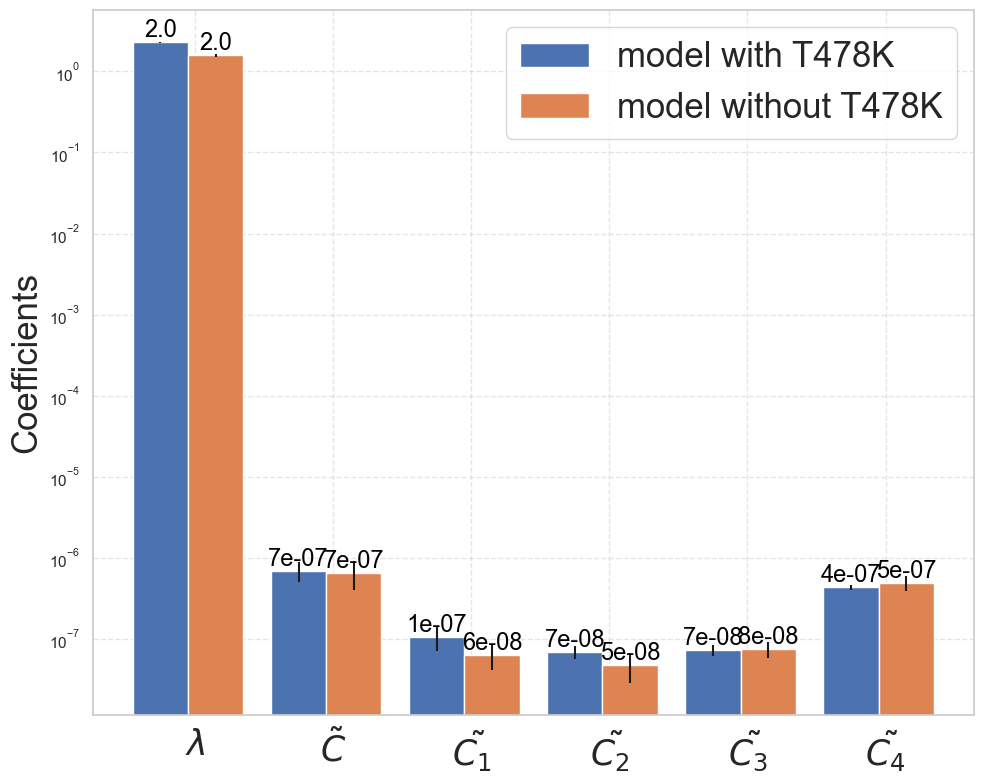

In [45]:




legend = [r'$\lambda$',r'$\tilde{C}$', r'$\tilde{C_1}$', r'$\tilde{C_2}$', r'$\tilde{C_3}$', r'$\tilde{C_4}$']


plt.figure(figsize=(10,8))
plt.bar(np.arange(len(coeffs_with_mean))*2, coeffs_with_mean, yerr=coeffs_with_std, width=0.8, label='model with T478K')
plt.bar(np.arange(len(coeffs_without_mean))*2+0.8, coeffs_without_mean, yerr=coeffs_without_std, width=0.8, label='model without T478K')
plt.yscale('log')
for i in range(len(coeffs_with_mean)):
    plt.text(i*2, 
                coeffs_with_mean[i], 
                round(coeffs_with_mean[i],int(-np.floor(np.log10(abs(coeffs_with_mean[i]))))),
                ha='center', va='bottom', 
                color='black',
                fontdict={'size': 17})

                
    plt.text(i*2+0.8, coeffs_without_mean[i], round(coeffs_without_mean[i],int(-np.floor(np.log10(abs(coeffs_without_mean[i]))))),
     ha='center', va='bottom', 
                color='black',
                fontdict={'size': 17})
                
plt.xticks(np.arange(len(coeffs_with_mean))*2+0.5, legend, 
           fontdict={'size': 25, 'weight': 'bold'})

           
           
plt.ylabel('Coefficients', fontsize=25)
plt.legend(fontsize=25)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('../paper/logistic_coeffs.png', dpi=300)

plt.show()


# Mutation ablation studies

mutations_truncated ['S:G339D', 'S:S371L', 'S:S373P', 'S:S375F', 'S:K417N', 'S:N440K', 'S:G446S', 'S:S477N', 'S:E484A', 'S:Q493R', 'S:G496S', 'S:Q498R', 'S:N501Y', 'S:Y505H']
df 1118
df_with 756
df_without 362
r2 score:  0.925617502519996
r2 score:  0.8649841493046528
r2 score:  0.8626667717662795
r2 score:  0.8611261781834925
r2 score:  0.8917635973503195
r2 score:  0.9156930423071913
r2 score:  0.9166416711691704


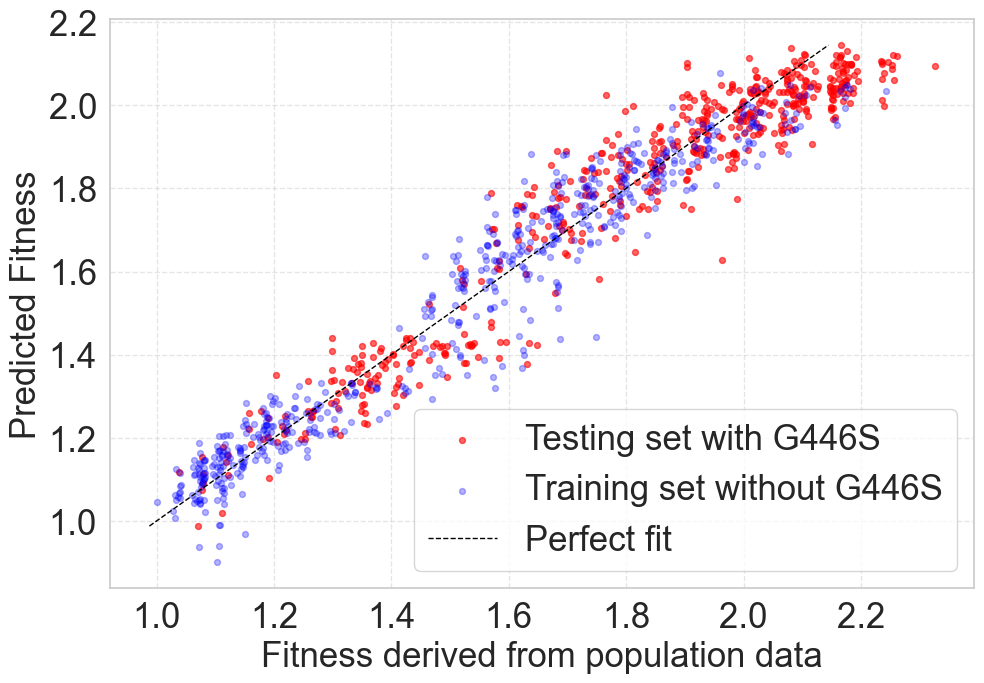

r2 score:  0.8250299830325019
r2 score:  0.864157399207104
r2 score:  0.9194544386466632
r2 score:  0.9007578902256899
r2 score:  0.9257785440541191
r2 score:  0.8810743279525721
r2 score:  0.9046763159283464


In [46]:
r2list=[]
mutations_truncated=['S:G339D',
 'S:S371L',
 'S:S373P',
 'S:S375F',
 'S:K417N',
 'S:N440K',
 'S:G446S',
 'S:S477N',
 'S:E484A',
 'S:Q493R',
 'S:G496S',
 'S:Q498R',
 'S:N501Y',
 'S:Y505H']
print('mutations_truncated',mutations_truncated)
print('df',len(df))
print('df_with',len(df_with))
print('df_without',len(df_without))
                     
for mu in mutations_truncated:
    df_with_with = df_with[df_with['mutations_x'].apply(lambda x: mu in x)]
    df_with_without = df_with[~df_with['mutations_x'].apply(lambda x: mu in x)]
    df_without_with = df_without[df_without['mutations_x'].apply(lambda x: mu in x)]
    df_without_without = df_without[~df_without['mutations_x'].apply(lambda x: mu in x)]
    X_with_with,y_with_with= df_with_with[ln_features].values,df_with_with['real_f'].values
    X_with_without,y_with_without= df_with_without[ln_features].values,df_with_without['real_f'].values
    X_without_with,y_without_with= df_without_with[ln_features].values,df_without_with['real_f'].values
    X_without_without,y_without_without= df_without_without[ln_features].values,df_without_without['real_f'].values

    param_with,_=curve_fit(logistic_model,X_with_without.T,y_with_without,p0=initial_guess,bounds=parameter_bounds,method='trf',maxfev=1000000)
    param_without,_=curve_fit(logistic_model,X_without_without.T,y_without_without,p0=initial_guess,bounds=parameter_bounds,method='trf',maxfev=1000000)
    
    y_with_with_pred=logistic_model(X_with_with.T,*param_with)
    y_without_with_pred=logistic_model(X_without_with.T,*param_without)

    y_with_pred=np.concatenate((y_without_with_pred,y_with_with_pred))
    y_with=np.concatenate((y_without_with,y_with_with))
    #add r2 of y_with_pred and y_with
    r2list.append(r2_score(y_with, y_with_pred))
    print('r2 score: ',r2_score(y_with, y_with_pred))
    #plot conccat_pred vs concat_test
    if mu=='S:G446S':
        plt.figure(figsize=(10, 7))
        plt.scatter(y_with, y_with_pred,  color='red', alpha=0.6, label='Testing set with G446S', s=18)
        plt.scatter(y_without_without, logistic_model(X_without_without.T,*param_without),  color='blue', alpha=0.3, label='Training set without G446S', s=18)
        plt.scatter(y_with_without, logistic_model(X_with_without.T,*param_with),  color='blue', alpha=0.3, s=18)
        plt.plot(np.unique(y_with_pred), np.unique(y_with_pred), color='black', linestyle='--', linewidth=1, label='Perfect fit')
        plt.xlabel('Fitness derived from population data', fontsize=25)
        plt.ylabel('Predicted Fitness', fontsize=25)
        plt.legend(fontsize=25)
        plt.xticks(fontsize=25)
        plt.yticks(fontsize=25)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()

        plt.savefig('../paper/log_pred_test_G446S.png',dpi=300)
        plt.show()


   

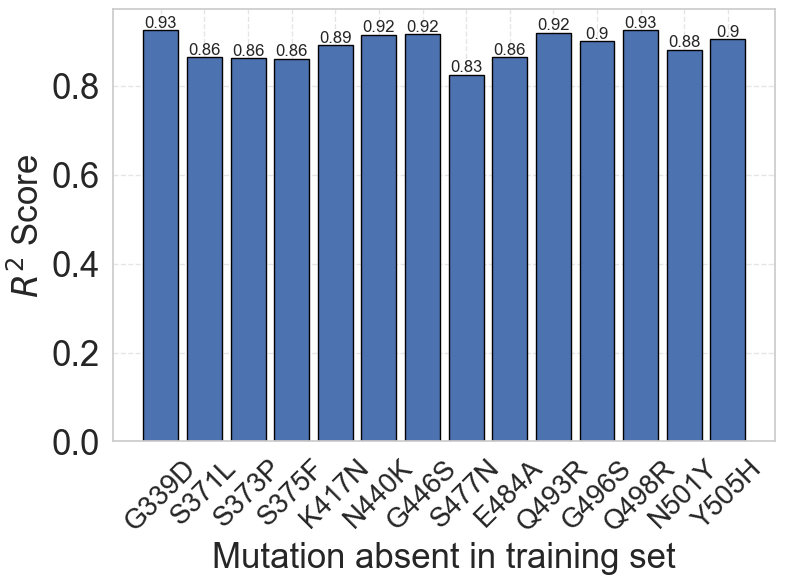

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))  

# Plot the bar chart
mutations_truncated_txt = [mut.replace('S:', '') for mut in mutations_truncated]
bars = ax.bar(mutations_truncated_txt, r2list)

ax.set_ylabel(r'$R^2$ Score', fontsize=25)  
ax.set_xlabel('Mutation absent in training set', fontsize=25)
ax.tick_params(axis='x', labelrotation=45, labelsize=10)  

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2),
            ha='center', va='bottom', fontsize=12)
    bar.set_edgecolor('black')
    bar.set_linewidth(1)
fig.tight_layout()
fig.subplots_adjust(bottom=0.25, left=0.15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=25)
plt.savefig('../paper/log_pred_test_mut.png', dpi=300)  
plt.show()
